In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import re
import pandas as pd
import numpy as np

### Load Unlabeled Data

In [3]:
!unzip '/content/drive/My Drive/labeled_data_new1.zip'
!unzip '/content/drive/My Drive/unlabeled_data_new1.zip'

Archive:  /content/drive/My Drive/labeled_data_new1.zip
  inflating: labeled_data_new1.csv   
Archive:  /content/drive/My Drive/unlabeled_data_new1.zip
  inflating: unlabeled_data_new1.csv  


In [4]:
df_unlabeled = pd.read_csv('unlabeled_data_new1.csv')
df_unlabeled.shape

(15472, 2)

In [5]:
df_unlabeled.head()

,filename,text
0,D36051.pdf.out.html.txt,janet ley approval sow mcw dba dmi mobility s...
1,D07271.pdf.out.html.txt,agreement this schedule a this schedule is att...
2,D28723.pdf.out.html.txt,wolters kluwer contingent staffing request fo...
3,D42247.pdf.out.html.txt,agreement received this agreement is entered i...
4,D19377.pdf.out.html.txt,addendum to hosting and services agreement thi...


### Load Labeled Data

In [6]:
df_labeled = pd.read_csv('labeled_data_new1.csv')
df_labeled.shape

(1397, 3)

In [7]:
df_labeled.head()

,filename,text,label
0,D00152.pdf.out.html.txt,addendum no to master services agreement this ...,Addendum
1,D16833.pdf.out.html.txt,addendum no to master services agreement this ...,Addendum
2,D08368.pdf.out.html.txt,agreement i to add effective as of january the...,Addendum
3,D38435.pdf.out.html.txt,amendment number one to work order this amendm...,Addendum
4,D00918.pdf.out.html.txt,agreement and or enrollment identified above t...,Addendum


### Regex Functions

In [0]:
def msa_regex_lookup(x):    
    nonmsa_keywords = ['sow', 'statement of work', 'addendum', 'amendment', 'confidentiality agreement', 'disclosure agreement']
    match1 = re.search(r"(agreement agreement|master agreement|master services agreement|this agreement)\s+(\S+\s+){1,30}(by and between|by and among|between|among)(.+?) and (.+?)", x.text)
    match2 = re.search(r"(agreement agreement|master agreement|master services agreement|this agreement)\s+(\S+\s+){1,30}(effective)(.+?) and (.+?)", x.text)
    match3 = re.search(r"(agreement agreement|master agreement|master services agreement|this agreement)\s+(\S+\s+){1,30}(the undersigned)(.+?) and (.+?)", x.text)
        
    if (match1 and not(any(key in x.text[:match1.end()] for key in nonmsa_keywords))) \
        or (match2 and not(any(key in x.text[:match2.end()] for key in nonmsa_keywords))) \
        or (match3 and not(any(key in x.text[:match3.end()] for key in nonmsa_keywords))):
        return 1
    return 0

def addendum_regex_lookup(x):
    match1 = re.search(r"(addendum|amendment|change request|change order)\s+(\S+\s+){1,30}(by and between|by and among|between) (.+?) and (.+?)", x.text)
    match2 = re.search(r"(addendum|amendment)\s+(\S+\s+){1,30}(schedule a|effective) (.+?) and (.+?)", x.text)
    match3 = re.search(r"(addendum|amendment) (.+?) (the undersigned) (.+?) and (.+?)", x.text)
    
    if (match1 and match1.start() < 1000) or (match2 and match2.start() < 1000) or (match3 and match3.start() < 1000):
        return 1
    return 0

def sow_regex_lookup(x):    
    nonsow_keywords = ['addendum','amendment']
    match1 = re.search(r"(sow|statement of work|work order|task order)\s+(\S+\s+){1,30}(by and between|by and among|executed by|between|entered into)(.+?) and (.+?)", x.text)
    match2 = re.search(r"(sow|statement of work|work order|task order)\s+(\S+\s+){1,30}(effective) (.+?) and (.+?)", x.text)
    match3 = re.search(r"(sow|statement of work|work order|task order)\s+(\S+\s+){1,30}(the undersigned) (.+?) and (.+?)", x.text)
       
    if (match1 and match1.start() < 1000 and not(any(key in x.text[:match1.end()] for key in nonsow_keywords)) \
        or (match2 and match2.start() < 1000 and not(any(key not in x.text[:match2.end()] for key in nonsow_keywords))) \
        or match3 and match3.start() < 1000 and not(any(key not in x.text[:match3.end()] for key in nonsow_keywords))):
        return 1
    return 0

def nda_regex_lookup(x):
    nda_keywords = ['mutual confidentiality', 'confidentiality agreement', 'disclosure agreement']
    match1 = re.search(r"(disclosure agreement|confidentiality agreement)\s+(\S+\s+){1,30}(by and between|by and among|between|among)(.+?) and (.+?)", x.text)
    
    if match1 and match1.start() < 1000 and any(key in x.text for key in nda_keywords):
        return 1
    return 0

def others_lookup(x):
    msa = msa_regex_lookup(x)
    sow = sow_regex_lookup(x)
    addendum = addendum_regex_lookup(x)
    nda = nda_regex_lookup(x)
    
    if msa == 0 and sow == 0 and addendum == 0 and nda == 0:
        return 1
    return 0    

### Keywords

In [0]:
msa_keywords = ['indemnified party', 'indemnifying party', 'force majeure', 'industrial property right', 'privacy restricted data', 
                'prior written notice', 'subject matter hereof']

addendum_keywords = ['addendum number', 'addendum date', 'addendum effective date',
                     'term of addendum', 'term of amendment', 'addendum made',
                     'addendum entered', 'duration of the addendum', 'purpose of the addendum', 
                     'subsequent addendum', 'amendment number', 'amendment date', 'amendment entered', 
                     'amendment made', 'amendment executed', 'amendment effective date', 
                     'agreement hereby amended', 'service agreement amendment']

sow_keywords = ['sow effective date', 'work sow', 'sow shall', 'sow term', 'client sow', 
                'sow agreement', 'statement of work effective', 'sow end date', 'sow duration']

nda_keywords = ['mutual confidentiality', 'affiliated entity', 'agreement negotiation', 'disclosure hereunder', 
                'mutual confidentiality agreement', 'non confidential basis', 'confidential information agent', 
                'confidentiality non disclosure', 'party certain confidential information',
                'party furnish']

other_keywords = ['sir madam', 'letter to inform', 'engagement letter', 'service order form',
                  'change request form', 'signature form', 'agreement service order', 'service component order', 
                  'component order', 'editorial service order']

### Create Latent Features

In [0]:
#Initialize empty dictionary and dataframe
#df_latent_train = pd.DataFrame()
df_latent_test = pd.DataFrame()
dict_latent = {}

#for index, row in df_unlabeled.iterrows():    
for index, row in df_labeled.iterrows():    
    #dict_latent['DocID'] = row["filename"]
            
    #============MSA=============
        
    #Check for matching MSA keywords
    for key in msa_keywords:
        if key in row['text']:            
            dict_latent[key] = 1             
        else:
            dict_latent[key] = 0

    #Call MSA regex lookup function
    dict_latent['msa_regex_lookup'] = msa_regex_lookup(row)
                
    #============SOW=============
            
    #Check for matching SOW keywords
    for key in sow_keywords:
        if key in row['text']:            
            dict_latent[key] = 1
        else:
            dict_latent[key] = 0

    #Call SOW regex lookup function
    dict_latent['sow_regex_lookup'] = sow_regex_lookup(row)
                
    #==========ADDENDUM=============
            
    #Check for matching Addnedum keywords
    for key in addendum_keywords:
        if key in row['text']:            
            dict_latent[key] = 1
        else:
            dict_latent[key] = 0

    #Call Addendum regex lookup function
    dict_latent['addendum_regex_lookup'] = addendum_regex_lookup(row)        
                
    #============NDA=============
        
    #Check for matching NDA keywords
    for key in nda_keywords:
        if key in row['text']:            
            dict_latent[key] = 1
        else:
            dict_latent[key] = 0

    #Call NDA regex lookup function
    dict_latent['nda_regex_lookup'] = nda_regex_lookup(row)
    
    #============Others===========
    
    #Check for matching Others keywords
    for key in other_keywords:
        if key in row['text']:            
            dict_latent[key] = 1
        else:
            dict_latent[key] = 0

    #Call Others regex lookup function
    dict_latent['others_lookup'] = others_lookup(row)                
    #break
    
    #Append dictionary to the DataFrame
    #df_latent_train = df_latent_train.append(dict_latent, ignore_index = True)
    df_latent_test = df_latent_test.append(dict_latent, ignore_index = True)

#fill NaNs with 0
#df_latent_train.fillna(0, inplace=True)
df_latent_test.fillna(0, inplace=True)

In [0]:
print(df_latent_train.shape, df_latent_test.shape)

(15472, 59) (1397, 59)


In [0]:
df_latent_train.head()

,addendum date,addendum effective date,addendum entered,addendum made,addendum number,addendum_regex_lookup,affiliated entity,agreement hereby amended,agreement negotiation,agreement service order,amendment date,amendment effective date,amendment entered,amendment executed,amendment made,amendment number,change request form,client sow,component order,confidential information agent,confidentiality non disclosure,disclosure hereunder,duration of the addendum,editorial service order,engagement letter,force majeure,indemnified party,indemnifying party,industrial property right,letter to inform,msa_regex_lookup,mutual confidentiality,mutual confidentiality agreement,nda_regex_lookup,non confidential basis,others_lookup,party certain confidential information,party furnish,prior written notice,privacy restricted data,purpose of the addendum,service agreement amendment,service component order,service order form,signature form,sir madam,sow agreement,sow duration,sow effective date,sow end date,sow shall,sow term,sow_regex_lookup,statement of work effective,subject matter hereof,subsequent addendum,term of addendum,term of amendment,work sow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
df_latent_test.head()

,addendum date,addendum effective date,addendum entered,addendum made,addendum number,addendum_regex_lookup,affiliated entity,agreement hereby amended,agreement negotiation,agreement service order,amendment date,amendment effective date,amendment entered,amendment executed,amendment made,amendment number,change request form,client sow,component order,confidential information agent,confidentiality non disclosure,disclosure hereunder,duration of the addendum,editorial service order,engagement letter,force majeure,indemnified party,indemnifying party,industrial property right,letter to inform,msa_regex_lookup,mutual confidentiality,mutual confidentiality agreement,nda_regex_lookup,non confidential basis,others_lookup,party certain confidential information,party furnish,prior written notice,privacy restricted data,purpose of the addendum,service agreement amendment,service component order,service order form,signature form,sir madam,sow agreement,sow duration,sow effective date,sow end date,sow shall,sow term,sow_regex_lookup,statement of work effective,subject matter hereof,subsequent addendum,term of addendum,term of amendment,work sow
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
for col in df_latent_train.columns.values:
    print(col, '-', sum(df_latent_train[col].values)) 

### Create Latent Features Count

In [0]:
#Initialize empty dictionary and dataframe
#df_latent_train = pd.DataFrame()
df_latent_test = pd.DataFrame()

#for index, row in df_unlabeled.iterrows():    
for index, row in df_labeled.iterrows():    
    dict_latent = {}
    msa_keywords_count = 0
    sow_keywords_count = 0
    nda_keywords_count = 0
    addendum_keywords_count = 0
    others_keywords_count = 0
            
    #============MSA=============
        
    #Check for matching MSA keywords
    for key in msa_keywords:
        if key in row['text']:
            msa_keywords_count += 1
    dict_latent['msa_keywords_count'] = msa_keywords_count

    #Call MSA regex lookup function
    dict_latent['msa_regex_lookup'] = msa_regex_lookup(row)
                
    #============SOW=============
            
    #Check for matching SOW keywords
    for key in sow_keywords:
        if key in row['text']:            
            sow_keywords_count += 1
    dict_latent['sow_keywords_count'] = sow_keywords_count

    #Call SOW regex lookup function
    dict_latent['sow_regex_lookup'] = sow_regex_lookup(row)
                
    #==========ADDENDUM=============
            
    #Check for matching Addnedum keywords
    for key in addendum_keywords:
        if key in row['text']:            
            addendum_keywords_count += 1
    dict_latent['addendum_keywords_count'] = addendum_keywords_count

    #Call Addendum regex lookup function
    dict_latent['addendum_regex_lookup'] = addendum_regex_lookup(row)        
                
    #============NDA=============
        
    #Check for matching NDA keywords
    for key in nda_keywords:
        if key in row['text']:            
            nda_keywords_count += 1
    dict_latent['nda_keywords_count'] = nda_keywords_count

    #Call NDA regex lookup function
    dict_latent['nda_regex_lookup'] = nda_regex_lookup(row)
    
    #============Others===========
    
    #Check for matching Others keywords
    for key in other_keywords:
        if key in row['text']:            
            others_keywords_count += 1
    dict_latent['others_keywords_count'] = others_keywords_count

    #Call Others regex lookup function
    dict_latent['others_lookup'] = others_lookup(row)                
    #break
    
    #Append dictionary to the DataFrame
    #df_latent_train = df_latent_train.append(dict_latent, ignore_index = True)
    df_latent_test = df_latent_test.append(dict_latent, ignore_index = True)

#fill NaNs with 0
#df_latent_train.fillna(0, inplace=True)
df_latent_test.fillna(0, inplace=True)

In [108]:
df_latent_test.head()

,addendum_keywords_count,addendum_regex_lookup,msa_keywords_count,msa_regex_lookup,nda_keywords_count,nda_regex_lookup,others_keywords_count,others_lookup,sow_keywords_count,sow_regex_lookup
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
df_latent_train.to_csv('/content/drive/My Drive/latent_features_count_train.csv', index=None)
df_latent_test.to_csv('/content/drive/My Drive/latent_features_count_test.csv', index=None)

### Load Latent Features

In [10]:
!unzip '/content/drive/My Drive/datafiles.zip'

Archive:  /content/drive/My Drive/datafiles.zip
  inflating: datafiles/latent_features_test.csv  
  inflating: datafiles/latent_features_train.csv  


In [0]:
df_latent_train = pd.read_csv('/content/drive/My Drive/latent_features_count_train.csv')
df_latent_test = pd.read_csv('/content/drive/My Drive/latent_features_count_test.csv')

In [111]:
print(df_latent_train.shape, df_latent_test.shape)

(15472, 10) (1397, 10)


### Stack Probabilities of LabelModel

In [112]:
df_probs_train = pd.read_csv('/content/drive/My Drive/lstm_79.6_probabilities_train.csv')
df_probs_test = pd.read_csv('/content/drive/My Drive/lstm_79.6_probabilities_test.csv')
print(df_probs_train.shape, df_probs_test.shape)

(15472, 2) (1397, 2)


In [113]:
df_probs_test.head()

,probabilities,label
0,"[0.888213038444519, 0.011493748985230923, 0.03...",0
1,"[0.8944848775863647, 0.016249872744083405, 0.0...",0
2,"[0.29428383708000183, 0.06875303387641907, 0.0...",0
3,"[0.9346663355827332, 0.004241131711751223, 0.0...",0
4,"[0.10538450628519058, 0.10119219869375229, 0.0...",0


In [0]:
#Separate probabilities from list and append to df_latent_train
prob1 = []
prob2 = []
prob3 = []
prob4 = []
prob5 = []

for i in range(len(df_probs_train)):
    prob1.append(float(df_probs_train['probabilities'][i].replace('[', '').replace(']','').split(',')[0]))
    prob2.append(float(df_probs_train['probabilities'][i].replace('[', '').replace(']','').split(',')[1]))
    prob3.append(float(df_probs_train['probabilities'][i].replace('[', '').replace(']','').split(',')[2]))
    prob4.append(float(df_probs_train['probabilities'][i].replace('[', '').replace(']','').split(',')[3]))
    prob5.append(float(df_probs_train['probabilities'][i].replace('[', '').replace(']','').split(',')[4]))
    
df_latent_train['prob1'] = prob1
df_latent_train['prob2'] = prob2
df_latent_train['prob3'] = prob3
df_latent_train['prob4'] = prob4
df_latent_train['prob5'] = prob5

#Append labels to df_latent_train
df_latent_train['label'] = df_probs_train.label.values

In [0]:
#Separate probabilities from list and append to df_latent_test
prob1 = []
prob2 = []
prob3 = []
prob4 = []
prob5 = []

for i in range(len(df_probs_test)):
    prob1.append(float(df_probs_test['probabilities'][i].replace('[', '').replace(']','').split(',')[0]))
    prob2.append(float(df_probs_test['probabilities'][i].replace('[', '').replace(']','').split(',')[1]))
    prob3.append(float(df_probs_test['probabilities'][i].replace('[', '').replace(']','').split(',')[2]))
    prob4.append(float(df_probs_test['probabilities'][i].replace('[', '').replace(']','').split(',')[3]))
    prob5.append(float(df_probs_test['probabilities'][i].replace('[', '').replace(']','').split(',')[4]))
    
df_latent_test['prob1'] = prob1
df_latent_test['prob2'] = prob2
df_latent_test['prob3'] = prob3
df_latent_test['prob4'] = prob4
df_latent_test['prob5'] = prob5

#Append labels to df_latent_test
df_latent_test['label'] = df_probs_test.label.values

In [116]:
print(df_latent_train.shape, df_latent_test.shape)

(15472, 16) (1397, 16)


In [117]:
df_latent_train.head()

,addendum_keywords_count,addendum_regex_lookup,msa_keywords_count,msa_regex_lookup,nda_keywords_count,nda_regex_lookup,others_keywords_count,others_lookup,sow_keywords_count,sow_regex_lookup,prob1,prob2,prob3,prob4,prob5,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.050951,0.037345,0.054494,0.806820,0.050391,3
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.443973,0.225379,0.099976,0.128059,0.102613,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068704,0.046902,0.067194,0.760013,0.057188,3
3,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.000985,0.069389,0.928129,0.000057,0.001441,2
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.723936,0.027038,0.056681,0.139216,0.053130,0


In [118]:
df_latent_test.head()

,addendum_keywords_count,addendum_regex_lookup,msa_keywords_count,msa_regex_lookup,nda_keywords_count,nda_regex_lookup,others_keywords_count,others_lookup,sow_keywords_count,sow_regex_lookup,prob1,prob2,prob3,prob4,prob5,label
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888213,0.011494,0.035360,0.015530,0.049403,0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.894485,0.016250,0.029001,0.009015,0.051249,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.294284,0.068753,0.060046,0.470195,0.106723,0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.934666,0.004241,0.021576,0.018400,0.021116,0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.105385,0.101192,0.076954,0.625772,0.090697,0


### Training

In [0]:
from numpy import loadtxt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MaxAbsScaler

In [0]:
x = df_latent_train.drop(['label'], axis=1).values
y = df_latent_train.label.values

In [218]:
x_scaled = MaxAbsScaler().fit_transform(x)
x_scaled

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.47069483e-02, 8.49067365e-01, 5.04371190e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00368012e-01, 1.34764368e-01, 1.02707172e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.74566563e-02, 7.99810092e-01, 5.72399874e-02],
       ...,
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        6.33425141e-04, 1.05742379e-06, 8.03262687e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.37104194e-02, 3.35689081e-04, 8.86545426e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.08815995e-03, 1.97331460e-04, 8.94595132e-01]])

In [0]:
x_test = df_latent_test.drop(['label'], axis=1).values
y_test = df_latent_test.label.values

In [219]:
x_test_scaled = MaxAbsScaler().fit_transform(x_test)
x_test_scaled

array([[5.00000000e-01, 1.00000000e+00, 0.00000000e+00, ...,
        3.55034387e-02, 1.83112041e-02, 4.94596841e-02],
       [5.00000000e-01, 1.00000000e+00, 0.00000000e+00, ...,
        2.91181105e-02, 1.06299579e-02, 5.13078126e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.02890835e-02, 5.54402576e-01, 1.06844819e-01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 5.71428571e-01, ...,
        8.15680928e-03, 2.80987816e-04, 1.08131694e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.59640268e-02, 7.02551935e-01, 9.58409108e-02],
       [0.00000000e+00, 0.00000000e+00, 1.42857143e-01, ...,
        8.05123312e-02, 1.11514362e-02, 4.96677891e-02]])

In [0]:
# split data into train and valid sets
x_train, x_valid, y_train, y_valid = train_test_split(x_scaled, y, test_size=0.02, random_state=22)

In [0]:
dtrain = xgb.DMatrix(data=x_train,label=y_train)
dvalid = xgb.DMatrix(data=x_valid,label=y_valid)

In [0]:
cv_params = {'reg_alpha': [0.1, 0.3, 0.5, 0.8, 1.0], 'reg_lambda': [0.1, 0.3, 0.5, 0.8, 1.0]}
ind_params = {'seed':22, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'multi:softmax', 'num_classes': 5, 'n_estimators': 25, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1 }
xgb_model = xgb.XGBClassifier(**ind_params)
optimized_GBM = GridSearchCV(xgb_model, 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1) 

In [210]:
optimized_GBM.fit(x_train, y_train, early_stopping_rounds=10, eval_set=[(x_valid, y_valid)], verbose=10)

[0]	validation_0-merror:0.016129
Will train until validation_0-merror hasn't improved in 10 rounds.
[10]	validation_0-merror:0.016129
Stopping. Best iteration:
[0]	validation_0-merror:0.016129



GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=25, n_jobs=1,
                                     nthread=None, num_classes=5,
                                     objective='multi:softmax', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=22, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'reg_alpha': [0.1, 0.3, 0.5, 0.8, 1.0],
                         'reg_lambda': [0.1, 0.3, 0.5

In [211]:
optimized_GBM.best_score_

0.9913599788946049

In [212]:
optimized_GBM.best_params_

{'reg_alpha': 0.1, 'reg_lambda': 0.1}

In [221]:
xgb_model = xgb.XGBClassifier(n_estimators = 25, learning_rate = 0.1, max_depth = 5, min_child_weight = 1, reg_alpha = 0.1, reg_lambda = 0.1)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=25, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [203]:
xgb_model.score(x_train, y_train)

0.9976915974145891

In [128]:
xgb_model.score(x_valid, y_valid)

0.9838709677419355

In [129]:
xgb_model.feature_importances_

array([0.00455557, 0.02960911, 0.00660283, 0.00541366, 0.01058842,
       0.00289664, 0.00117685, 0.02132165, 0.00441827, 0.00431366,
       0.18053834, 0.16777425, 0.09702867, 0.26628032, 0.19748177],
      dtype=float32)

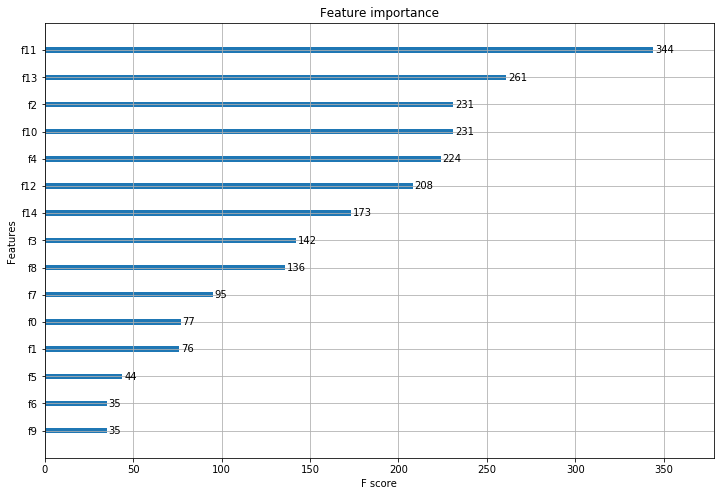

In [130]:
import matplotlib.pyplot as plt
#xgb_model.get_booster().feature_names = df_latent_train.drop(drop_features, axis=1).columns.tolist()
xgb.plot_importance(xgb_model)
plt.rcParams['figure.figsize'] = [12, 8]
plt.show()

### Predict

In [222]:
# make predictions for test data and evaluate
y_pred = xgb_model.predict(x_test_scaled)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.25%


### Save Model

In [0]:
import pickle
pickle.dump(xgb_model, open("/content/drive/My Drive/xgb_83.04.dat", "wb"))

### LightGBM

In [0]:
import lightgbm as lgb

In [0]:
cv_params = {'reg_alpha': [0.1, 0.2, 0.5, 0.8, 1.0], 'reg_lambda': [0.1, 0.2, 0.5, 0.8, 1.0]}
ind_params = {'seed':22, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'multiclass', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 0.1, 'n_estimators': 100}
lgb_model = lgb.LGBMClassifier(**ind_params)
optimized_LGB = GridSearchCV(lgb_model, 
                            cv_params, 
                            scoring = 'accuracy', cv = 5, n_jobs = -1) 


In [171]:
optimized_LGB.fit(x_train, y_train, early_stopping_rounds=10, eval_set=[(x_valid, y_valid)], verbose=10)

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.422549
[20]	valid_0's multi_logloss: 0.175789
[30]	valid_0's multi_logloss: 0.0899708
[40]	valid_0's multi_logloss: 0.0552418
[50]	valid_0's multi_logloss: 0.04054
[60]	valid_0's multi_logloss: 0.0323497
[70]	valid_0's multi_logloss: 0.0282761
[80]	valid_0's multi_logloss: 0.0255281
[90]	valid_0's multi_logloss: 0.0235089
[100]	valid_0's multi_logloss: 0.0209874
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0209874


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=0.8,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=3,
                                      min_child_samples=20,
                                      min_child_weight=0.1, min_split_gain=0.0,
                                      n_estimators=100, n_jobs=-1,
                                      num_leaves=31, objective='multiclass',
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, seed=22, silent=True,
                                      subsample=0.8, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'reg_alpha': [0.1, 0.2, 0.5, 0.8, 1.0],
       

In [172]:
optimized_LGB.best_score_

0.9959767840654268

In [173]:
optimized_LGB.best_params_

{'reg_alpha': 0.1, 'reg_lambda': 0.1}

In [223]:
lgb_model = lgb.LGBMClassifier(learning_rate = 0.1, max_depth = 3, min_child_weight = 0.1, n_estimators = 100, reg_alpha=0.1)
lgb_model.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=3,
               min_child_samples=20, min_child_weight=0.1, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.1, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [224]:
# make predictions for test data and evaluate
y_pred = lgb_model.predict(x_test_scaled)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.82%


In [0]:
pickle.dump(lgb_model, open("/content/drive/My Drive/lgb_83.82.dat", "wb"))